<a href="https://www.kaggle.com/code/dascient/kepler-exoplanet-classification-model?scriptVersionId=127765407" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Kepler Data Analysis

In [26]:
# lets begin!
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
# for the sake of expeditious analysis
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from wordcloud import WordCloud, STOPWORDS
from geopandas import GeoDataFrame
import matplotlib.colors as colors
import seaborn as sns
import random as r
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# kepler labled test & train
exoTest = pd.read_csv('/kaggle/input/kepler-labelled-time-series-data/exoTest.csv',header=0)
exoTrain = pd.read_csv('/kaggle/input/kepler-labelled-time-series-data/exoTrain.csv',header=0)
cumulative = pd.read_csv('/kaggle/input/kepler-exoplanet-search-results/cumulative.csv',header=0)


/kaggle/input/kepler-exoplanet-search-results/cumulative.csv
/kaggle/input/kepler-labelled-time-series-data/exoTest.csv
/kaggle/input/kepler-labelled-time-series-data/exoTrain.csv


In [3]:
# datasets
#exoTest.describe()#.style.background_gradient(cmap ='coolwarm').set_properties(**{'font-size': '8px'})
#exoTrain.describe()#.style.background_gradient(cmap ='coolwarm').set_properties(**{'font-size': '8px'})
#cumulative.describe()#.style.background_gradient(cmap ='coolwarm').set_properties(**{'font-size': '8px'})

In [4]:
# kepler target
# pairplot
#target = 'kepler_name'#'koi_disposition'
#sns.pairplot(df_encoded.sample(int(len(df_encoded/1000))),hue=target)
#sns.pairplot(df_encoded.sample(10),hue=target)

In [21]:
exoTest

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,...,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,...,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,...,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,...,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,...,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,1,374.46,326.06,319.87,338.23,251.54,209.84,186.35,167.46,135.45,...,-123.55,-166.90,-222.44,-209.71,-180.16,-166.83,-235.66,-213.63,-205.99,-194.07
566,1,-0.36,4.96,6.25,4.20,8.26,-9.53,-10.10,-4.54,-11.55,...,-12.40,-5.99,-17.94,-11.96,-12.11,-13.68,-3.59,-5.32,-10.98,-11.24
567,1,-54.01,-44.13,-41.23,-42.82,-39.47,-24.88,-31.14,-24.71,-13.12,...,-0.73,-1.64,1.58,-4.82,-11.93,-17.14,-4.25,5.47,14.46,18.70
568,1,91.36,85.60,48.81,48.69,70.05,22.30,11.63,37.86,28.27,...,2.44,11.53,-16.42,-17.86,21.10,-10.25,-37.06,-8.43,-6.48,17.60


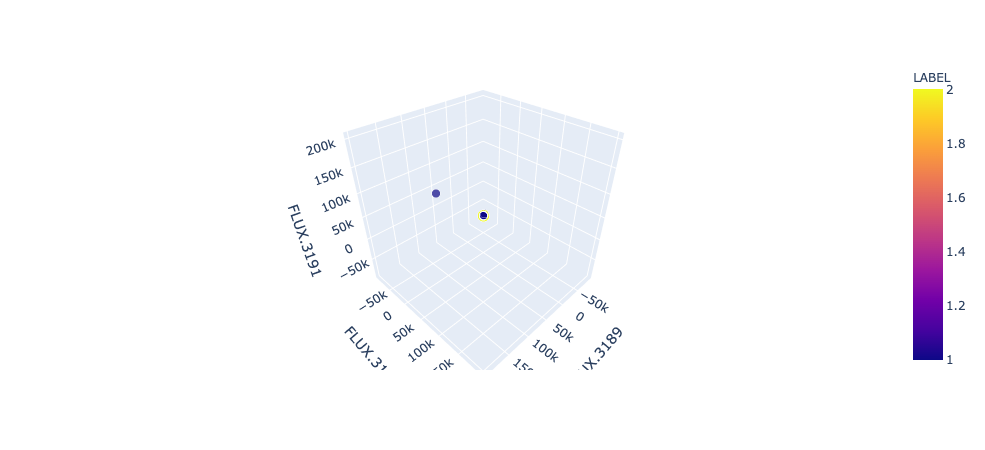

In [24]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

fig = px.scatter_3d(exoTest.sample(500), x='FLUX.3189', y='FLUX.3190', z='FLUX.3191',
              color='LABEL',
              size = 'LABEL',
              #symbol = 'state',
              #opacity=0.7,
              #size_max=13,                    
                   )
fig.show()

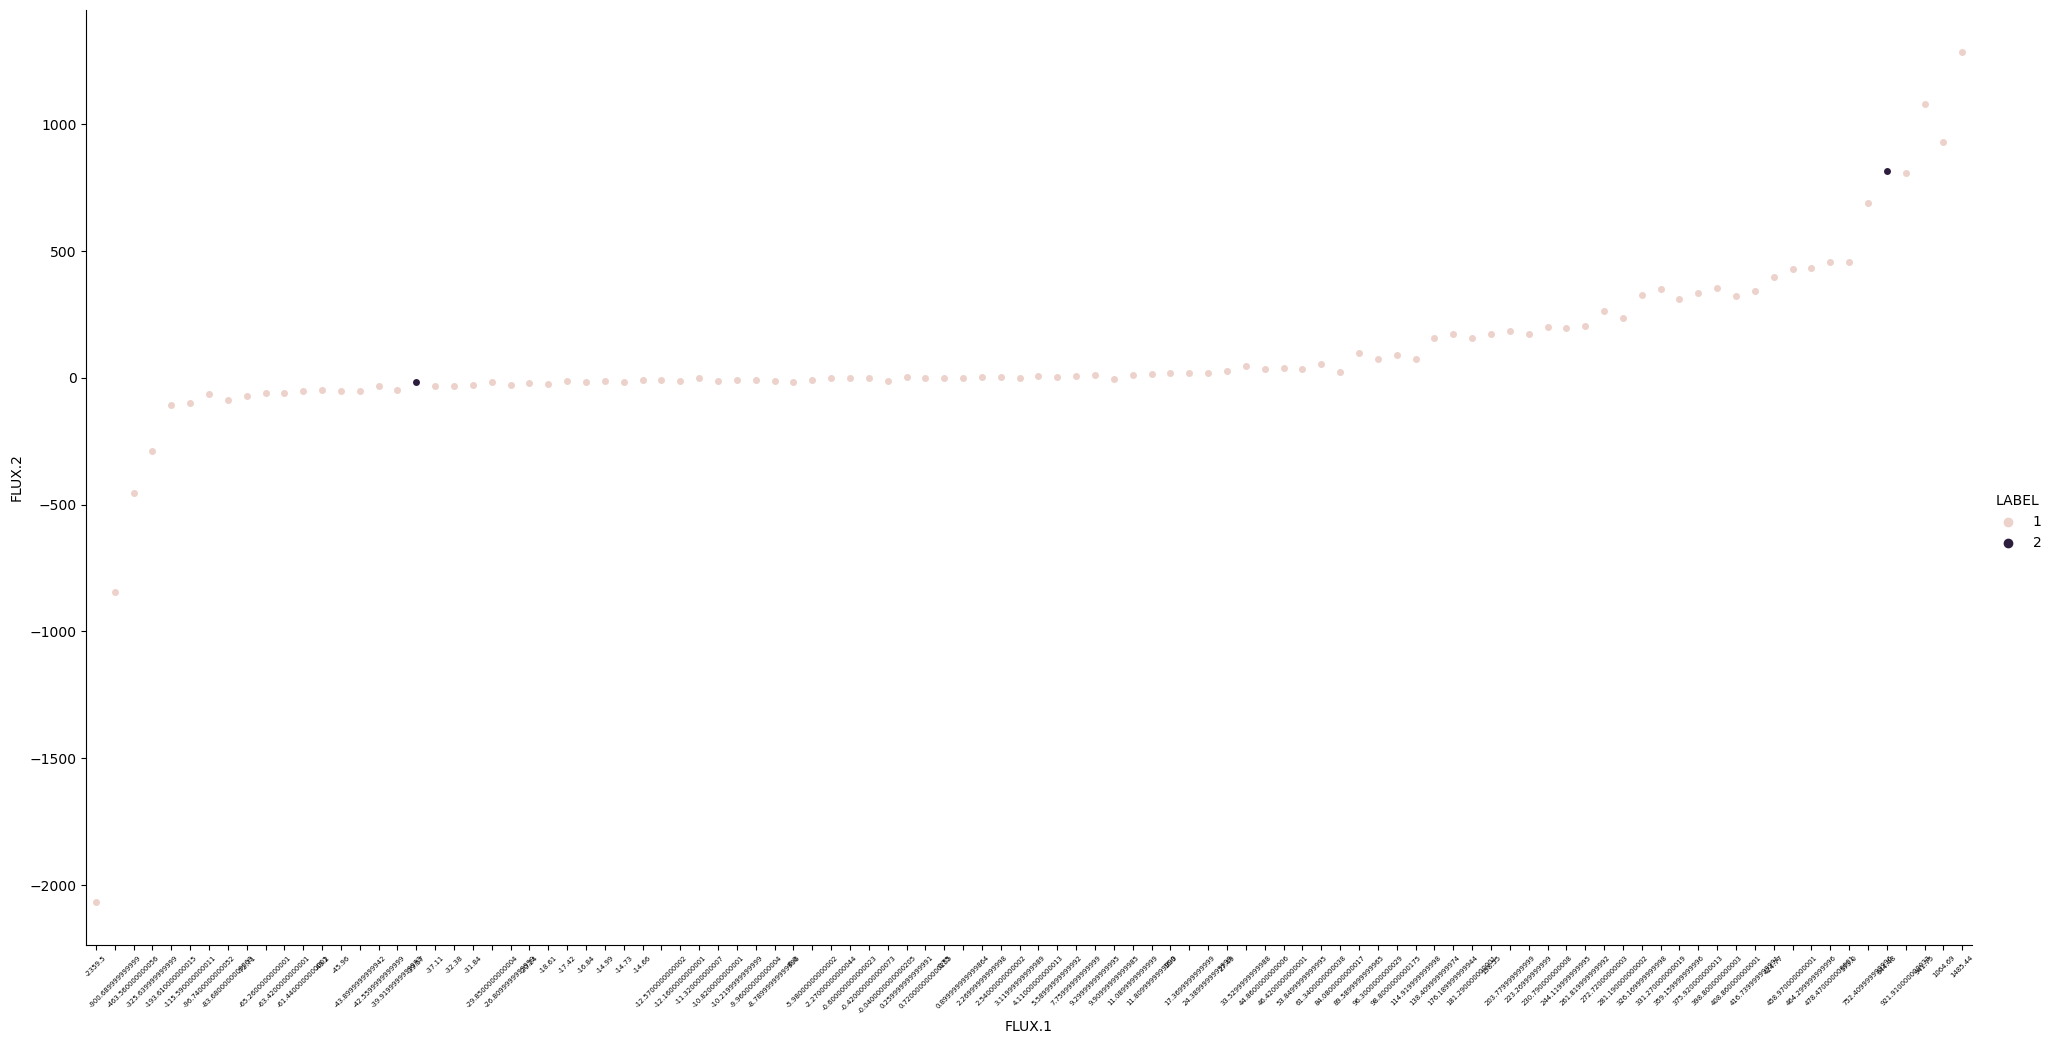

In [27]:
import seaborn as sns

plt.rcParams["xtick.labelsize"] = 5

# plot a sample of 100 observations that lasted under 60 minutes
# need to get a smaller sample of city-set, the x-axis is way too muddled.
sns.catplot(data=exoTest.sample(100), x="FLUX.1", 
            y="FLUX.2", 
            hue="LABEL", 
            kind="swarm", 
            height=10, 
            aspect=2, 
            size = 5)
plt.xticks(rotation=45)
plt.show()

In [17]:
# Set up Xy Test & Train sets
X_train, X_test, y_train, y_test = exoTrain.drop(columns='LABEL'), exoTest.drop(columns='LABEL'), exoTrain.LABEL.values, exoTest.LABEL.values

# ML

In [22]:
target = 'LABEL'

# classifier
#clf = RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42).fit(X_train, y_train)
#clf = AdaBoostClassifier(n_estimators=200, random_state=42).fit(X_train, y_train)
clf = ExtraTreesClassifier(n_estimators=200, random_state=42).fit(X_train, y_train)
#clf = KNeighborsClassifier().fit(X_train, y_train)
#clf = MLPClassifier(alpha=1, max_iter=500).fit(X_train, y_train)

# results
train_predications = clf.predict(X_train)
train_score = clf.score(X_train, y_train)
predictions = clf.predict(X_test)
score = clf.score(X_test, y_test)
train_matrix = confusion_matrix(y_train, train_predications)
test_matrix = confusion_matrix(y_test, predictions)
print("Target:",target)
print("TRAIN SCORE:",train_score)
print("TEST SCORE:",score)

Target: LABEL
TRAIN SCORE: 1.0
TEST SCORE: 0.9912280701754386


In [ ]:
matrix = pd.DataFrame(test_matrix)

matrix.style.background_gradient(cmap ='Spectral')\
        .set_properties(**{'font-size': '15px'})

<AxesSubplot:>

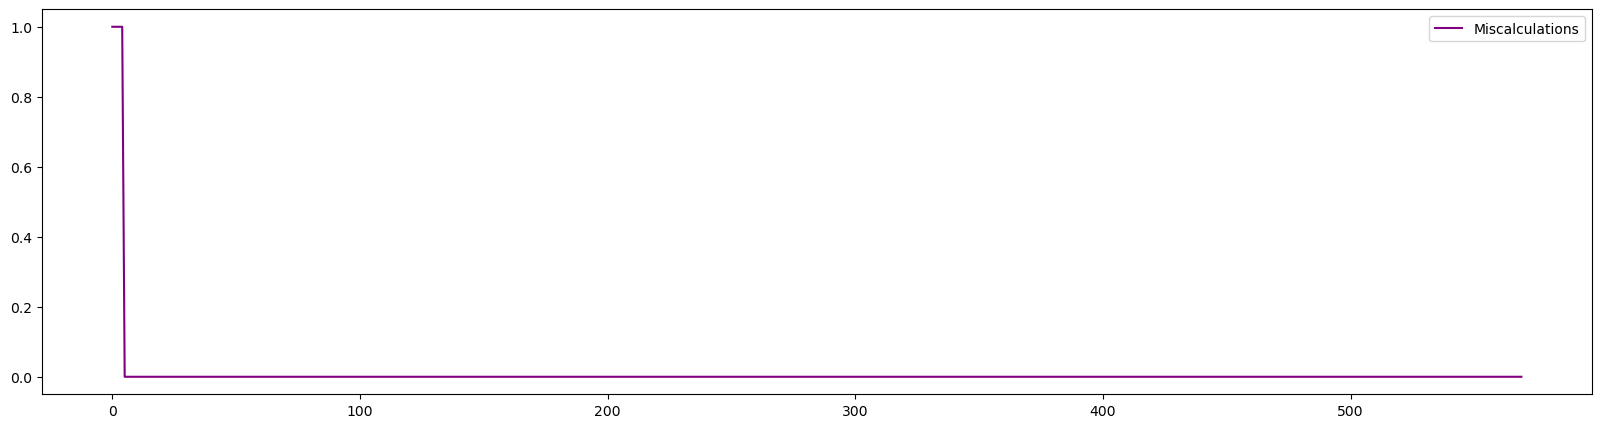

In [23]:
# noise
pd.DataFrame(y_test-clf.predict(X_test),columns=['Miscalculations']).plot(figsize=(20,5),c='purple')

In [24]:
import time

# iterator
def classification_feat_importance(df_encoded):
    
    # iterate through each column variable as classification targets
    for target in exoTrain.columns.values:
        time.sleep(30)
        
        # classifiers
        #clf1 = RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42).fit(X_train, y_train)
        clf2 = AdaBoostClassifier(n_estimators=200, random_state=42).fit(X_train, y_train)
        #clf3 = ExtraTreesClassifier(n_estimators=200, random_state=42).fit(X_train, y_train)
        #clf4 = KNeighborsClassifier().fit(X_train, y_train)
        #clf5 = MLPClassifier(alpha=1, max_iter=500).fit(X_train, y_train)
        classifiers = [
                       #clf1, 
                       clf2, 
                       #clf3, 
                       #clf4, 
                       #clf5
                      ]

        for classifier in classifiers:
            results = []
            #test_matrix = confusion_matrix(y_test, clf.predict(X_test))
            results.append({"classifier":str(classifier).split("(")[0],"target":target,"test_score":classifier.score(X_test, y_test)})
            print("Classifier:",str(classifier).split("(")[0],"\t\tTarget:",target,"\tScore:",classifier.score(X_test, y_test))
            
    return pd.DataFrame(results)

In [ ]:
classification_feat_importance(df_encoded)

In [ ]:
# choose target variable
#target = input("Enter target variable: ")
target = 'kepler_name'#"koi_disposition"

# quick proof of concept
a = df.copy()

# find random sample
from random import randrange
idx = randrange(len(a))

# print random configuration item
b = pd.DataFrame(a.loc[idx]).T
print(f"{target}:",b.reset_index()[target][0])

# store sol'n
solution = b.reset_index()[target][0]

# print data point
b

In [ ]:
# categorize/encode entire dataframe(a)
def encode(df):
    lb_make = LabelEncoder()
    columns = df.columns.values.tolist()
    df_encoded = df[columns].copy()

    # categorize/encode
    for i in columns:
        df_encoded[i] = lb_make.fit_transform(df[i])

    # encoded
    return df_encoded

c = encode(a)
print("\nOriginal dataframe encoded.")

In [ ]:
# print encoded item
use_case = pd.DataFrame(c.loc[idx]).T.drop(columns=[target]) 
#c

# print encoded item w/out target info
data = c.drop(columns=[target]) 
use_case

In [ ]:
def X_y_sets(df, target):
    #X = df.dropna().drop(columns=[target]).copy()
    #y = df.dropna()[target].ravel().copy()
    
    # w.o dropna()
    X = df.drop(columns=[target]).copy()
    y = df.dropna()[target].ravel().copy()
    
    return train_test_split(X, y, test_size=0.33, random_state=42), X, y# save trainer
print("\nResetting train data...")
trainer = c.loc[c.index!=idx].dropna().copy()
X, y =  trainer.drop(columns=[target]), trainer[target].ravel()
X_train, X_test, y_train, y_test = X_y_sets(trainer, target)[0]

In [ ]:
print("\nLive prediction\n")

# choose classifier
#clf = GradientBoostingClassifier(criterion="friedman_mse", init=None, learning_rate=0.033, loss='deviance', max_depth=19, max_features=None, max_leaf_nodes=None, min_samples_leaf=60, min_samples_split=120, min_weight_fraction_leaf=0.0, n_estimators=100, random_state=42, subsample=1.0, verbose=1, warm_start=False).fit(X_train, y_train)
#clf = RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42).fit(X_train, y_train)
#clf = ExtraTreesClassifier(n_estimators=200, random_state=42).fit(X_train, y_train)
clf = AdaBoostClassifier(n_estimators=200, random_state=42).fit(X_train, y_train)
#clf = MLPClassifier(alpha=1, max_iter=500).fit(X_train, y_train)
#clf = KNeighborsClassifier().fit(X_train, y_train)


print()
print("Test score: ",clf.score(X_test, y_test))
print()
prediction = clf.predict(use_case)[0]
print(f"Prediction {target}:",prediction)


# print decoded prediction
print("\nPrediction Decoded")
e = d[d.index == prediction]
e

In [ ]:
if solution == e.reset_index()[target][0]:
    print("Machine's prediction was correct!")
else:
    print("Machine's prediction was incorrect :(")

- I believe the machine's inability to predict correctly is due to a class-oriented issue in the cell above in which I define the X_y_sets function. 
- I might be seeking @jasonifier as an SME to address this issue by uniquely debugging my code. Otherwise, feel free to comment as to why setting the X variable  [(df.dropna().drop(columns=[target]).copy()] returns an empty set - Despite having X_test.info() identifies each variable to be non-null's?
- I'll be attending to fix this as quickly as I can. 

# Supplementary

In [ ]:
# encoding
from sklearn.preprocessing import LabelEncoder
def encode(df):
    lb_make = LabelEncoder()
    columns = df.columns.values.tolist()
    df_encoded = df[columns].copy()

    # categorize/encode
    for i in columns:
        df_encoded[i] = lb_make.fit_transform(df[i])

    # encoded
    return df_encoded


# encoded variable re-mapping
def encoding_remap(df, df_encoded, target):
    
    X_test = X_y_sets(df, target)[0][0]
    
    remap = pd.merge(df_encoded.loc[df_encoded.index.isin(X_test.index.values)][target].reset_index(),
              df.loc[df.index.isin(X_test.index.values)][[target]].reset_index(),on=['index'])
    
    remap[target] = [str(remap[f'{target}_y'][i]) for i,v in remap[f'{target}_x'].items()]
    remap['index'] = np.array([str(remap[f'{target}_x'][i]) for i,v in remap[f'{target}_x'].items()]).astype(int)
    remap=remap[[target,'index']]
    remap = remap.set_index('index').drop_duplicates().sort_values('index')
    
    return remap


# pairplot
import seaborn as sns
def pairplot(df, target):
    return sns.pairplot(df.sample(int(len(df/10000))),hue=target)
    
    
# create X,y variables for ML
from sklearn.model_selection import train_test_split
def X_y_sets(df, target):
    X = df.dropna().drop(columns=[target]).copy()
    y = df.dropna()[target].ravel().copy()
    
    return train_test_split(X, y, test_size=0.33, random_state=42), X, y


# classifier iteration
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
def classification_feat_importance(df_encoded):
    
    df_encoded = df_encoded.drop(columns=['target1','target2'])
    
    # iterate through each column variable as classification targets
    for target in df_encoded.columns.values:
        X = df_encoded.dropna().drop(columns=[target]).copy()
        y = df_encoded.dropna()[target].ravel().copy()

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        
        time.sleep(30)
        
        # classifiers
        clf1 = RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42).fit(X_train, y_train)
        clf2 = AdaBoostClassifier(n_estimators=200, random_state=42).fit(X_train, y_train)
        clf3 = ExtraTreesClassifier(n_estimators=200, random_state=42).fit(X_train, y_train)
        clf4 = KNeighborsClassifier().fit(X_train, y_train)
        clf5 = MLPClassifier(alpha=1, max_iter=500).fit(X_train, y_train)
        classifiers = [
                       clf1, 
                       clf2, 
                       clf3, 
                       clf4, 
                       clf5
                      ]

        for classifier in classifiers:
            results = []
            #test_matrix = confusion_matrix(y_test, clf.predict(X_test))
            results.append({"classifier":str(classifier).split("(")[0],"target":target,"test_score":classifier.score(X_test, y_test)})
            print("Classifier:",str(classifier).split("(")[0],"\t\tTarget:",target,"\tScore:",classifier.score(X_test, y_test))
            
    return pd.DataFrame(results)

## Variable Definitions & API Documentation
Data Columns in Kepler Objects of Interest Table <br>*https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html


Exoplanet Archive Application Programming Interface (API) User Guide
<br>*https://exoplanetarchive.ipac.caltech.edu/docs/program_interfaces.html

In [ ]:
#en fin